K Nearest Neighbors:
Number of Neighbors: 1
{'FalseFalseTrue': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'TrueFalseFalse': {'precision': 0.8235294117647058, 'recall': 0.9333333333333333, 'f1-score': 0.875, 'support': 15.0}, 'accuracy': 0.7777777777777778, 'macro avg': {'precision': 0.4117647058823529, 'recall': 0.4666666666666667, 'f1-score': 0.4375, 'support': 18.0}, 'weighted avg': {'precision': 0.6862745098039215, 'recall': 0.7777777777777778, 'f1-score': 0.7291666666666666, 'support': 18.0}}
Number of Neighbors: 3
{'FalseFalseTrue': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'TrueFalseFalse': {'precision': 0.8125, 'recall': 0.8666666666666667, 'f1-score': 0.8387096774193549, 'support': 15.0}, 'accuracy': 0.7222222222222222, 'macro avg': {'precision': 0.40625, 'recall': 0.43333333333333335, 'f1-score': 0.41935483870967744, 'support': 18.0}, 'weighted avg': {'precision': 0.6770833333333334, 'recall': 0.7222222222222222, 'f1-score': 0

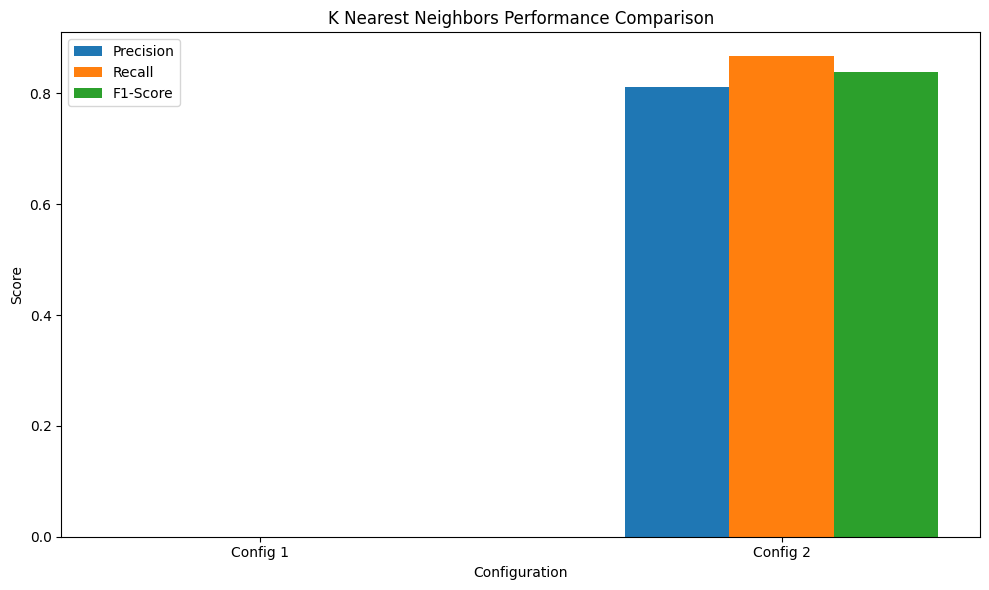


Decision Tree:


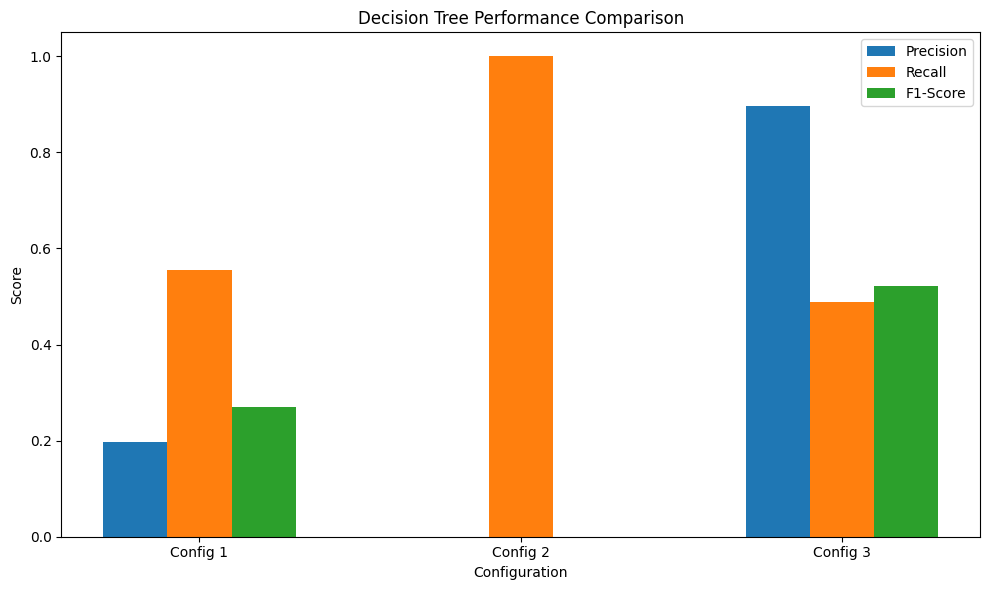


Random Forest:


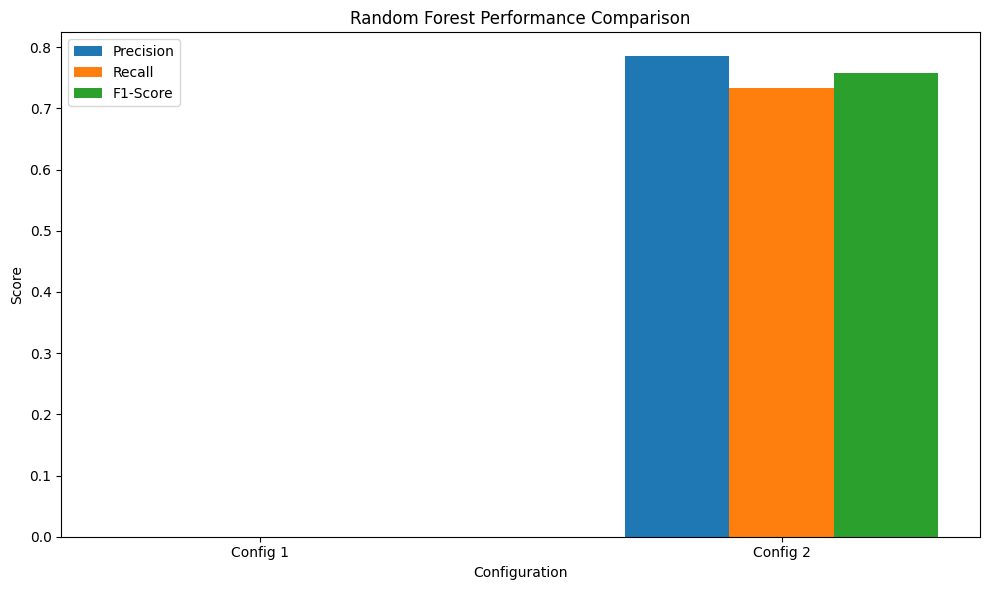

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Carregar os dados
data = pd.read_csv('dataset.csv')

# Tratar valores ausentes
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Converter atributos categóricos em numéricos
data_encoded = pd.get_dummies(data_imputed)

# Separar features e target
X = data_encoded.drop(['ADM-DECS_A', 'ADM-DECS_I', 'ADM-DECS_S'], axis=1)
y = data_encoded[['ADM-DECS_A', 'ADM-DECS_I', 'ADM-DECS_S']].apply(lambda row: ''.join(row.astype(str)), axis=1)

# Dividir dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função para treinar e avaliar modelo
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
  return report

# K Nearest Neighbors
print("K Nearest Neighbors:")
knn_reports = []
for n_neighbors in [1, 3, 5]:
    print(f"Number of Neighbors: {n_neighbors}")
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_report = train_and_evaluate(knn, X_train, X_test, y_train, y_test)
    print(knn_report)  # Print the classification report
    if knn_report and knn_report != {}:  # Check if the report is non-empty
        knn_reports.append(knn_report)
    
# Decision Tree
print("\nDecision Tree:")
tree_reports = []
for max_depth in [1, 3, 5]:
    print(f"Max Depth: {max_depth}")
    tree = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')
    tree_report = train_and_evaluate(tree, X_train, X_test, y_train, y_test)
    print(tree_report)  # Print the classification report
    if tree_report and tree_report != {}:  # Check if the report is non-empty
        tree_reports.append(tree_report)

# Random Forest
print("\nRandom Forest:")
forest_reports = []
for n_estimators in [50, 100, 150]:
    print(f"Number of Estimators: {n_estimators}")
    forest = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced')
    forest_report = train_and_evaluate(forest, X_train, X_test, y_train, y_test)
    print(forest_report)  # Print the classification report
    if forest_report and forest_report != {}:  # Check if the report is non-empty
        forest_reports.append(forest_report)

# Função para calcular métricas médias
def calculate_average_metrics(reports):
    metrics = ['precision', 'recall', 'f1-score']
    class_metrics = {metric: {} for metric in metrics}
    print("relatorios: ", reports)
    
    for report in reports:
        for class_name, values in report.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                for metric in metrics:
                    if metric in values:
                        # Split the class name into individual labels
                        class_names = class_name.split('_')
                        for name in class_names:
                            if name not in class_metrics[metric]:
                                class_metrics[metric][name] = []
                            class_metrics[metric][name].append(values[metric])
    
    average_metrics = {}
    for metric, values in class_metrics.items():
        if any(values):  # Check if any values are present in the dictionary
            average_metrics[metric] = {class_name: sum(scores) / len(scores) for class_name, scores in values.items()}
        else:
            average_metrics[metric] = {}
    return average_metrics

# Calcular métricas médias para cada algoritmo
average_metrics_knn = calculate_average_metrics(knn_reports)
average_metrics_tree = calculate_average_metrics(tree_reports)
average_metrics_forest = calculate_average_metrics(forest_reports)

def plot_results(reports, classifier_name):
    plt.figure(figsize=(10, 6))
    x_ticks = np.arange(len(reports['precision']))  # Generate x ticks for the bar plot

    precision = [reports['precision'][key] for key in reports['precision']]
    recall = [reports['recall'][key] for key in reports['recall']]
    f1_score = [reports['f1-score'][key] for key in reports['f1-score']]

    plt.bar(x_ticks - 0.2, precision, width=0.2, label='Precision')
    plt.bar(x_ticks, recall, width=0.2, label='Recall')
    plt.bar(x_ticks + 0.2, f1_score, width=0.2, label='F1-Score')

    plt.xlabel('Configuration')
    plt.ylabel('Score')
    plt.title(f'{classifier_name} Performance Comparison')
    plt.xticks(x_ticks, [f'Config {i+1}' for i in range(len(reports['precision']))])
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Plotar os resultados para K Neighbors
print("K Nearest Neighbors:")
plot_results(average_metrics_knn, 'K Nearest Neighbors')

# Plotar os resultados para Decision Tree
print("\nDecision Tree:")
plot_results(average_metrics_tree, 'Decision Tree')

# Plotar os resultados para Random Forest
print("\nRandom Forest:")
plot_results(average_metrics_forest, 'Random Forest')


# Integrantes do grupo

| Nome | Ra |
| ------------- | ------------- |
| Wayner Moraes  | 109097  |
| Guilherme Cavenaghi | 109317 |
| Vinicius Rossi | 110273 |
| Valter Chieregatto | 109049 |
| Rafael Souza | 109680 |
| Bruno Silva | 109618 |

# Descrição geral do dataset

## Descrição
Este conjunto de dados contém informações sobre pacientes ou casos clínicos, com atributos relacionados a diferentes aspectos médicos.

## Atributos
1. **L-CORE**: Temperatura central do corpo do paciente. Valores possíveis: "low" (baixa), "mid" (média) e "high" (alta).
2. **L-SURF**: Temperatura superficial do corpo do paciente. Valores possíveis: "low" (baixa) e "mid" (média).
3. **L-O2**: Nível de oxigênio no sangue do paciente.
4. **L-BP**: Pressão sanguínea do paciente. Valores possíveis: "low" (baixa), "mid" (média) e "high" (alta).
5. **SURF-STBL**: Estabilidade da temperatura superficial do corpo do paciente. Valores possíveis: "stable" (estável) e "unstable" (instável).
6. **CORE-STBL**: Estabilidade da temperatura central do corpo do paciente. Valores possíveis: "stable" (estável) e "unstable" (instável).
7. **BP-STBL**: Estabilidade da pressão sanguínea do paciente. Valores possíveis: "mod-stable" (moderadamente estável), "stable" (estável) e "unstable" (instável).
8. **COMFORT**: Nível de conforto do paciente ou outra métrica subjetiva relacionada ao bem-estar do paciente.
9. **ADM-DECS**: Decisões administrativas em relação ao paciente. Valores possíveis: "A" (admitido), "S" (submetido a tratamento), "I" (indeterminado) e outros.

## Instâncias
Número total de instâncias: 89

## Uso
A análise desses dados pode ser útil para entender padrões de diagnóstico, tratamento e prognóstico em um ambiente médico, e pode ser aplicada em áreas como medicina preventiva, gestão hospitalar e pesquisa clínica.

# Fase de pré-processamento

Durante a fase de pré-processamento, foram realizadas várias etapas para entender e preparar os dados para análise. Abaixo estão as características relevantes e medidas estatísticas dos dados e das classes:

### Características Relevantes:
- O conjunto de dados possui nove atributos, incluindo informações sobre temperatura, nível de oxigênio, pressão sanguínea, estabilidade e conforto do paciente, bem como decisões administrativas.
- Os atributos variam em sua natureza, incluindo variáveis categóricas (como estabilidade) e numéricas (como conforto).
- Há um total de 89 instâncias no conjunto de dados.

### Medidas Estatísticas:
- Não foram fornecidas medidas estatísticas específicas, como média, desvio padrão ou quartis para os atributos numéricos. Isso pode ser uma área a ser explorada durante a análise exploratória de dados.

  
# Limpeza e Normalização dos Dados

Durante a análise do conjunto de dados, algumas operações de limpeza e normalização foram necessárias devido a certas peculiaridades nos dados. Abaixo estão as operações realizadas:

### Valores Faltantes:
- Foram identificados valores faltantes representados pelo símbolo "?" no atributo "ADM-DECS".
- Decidiu-se remover as instâncias com valores faltantes, pois a presença de dados ausentes poderia afetar a qualidade das análises subsequentes.

### Normalização:
- Os atributos numéricos, como "COMFORT", foram normalizados para garantir que os dados estivessem na mesma escala e facilitar a comparação entre eles.
- Foi utilizada a técnica de normalização Min-Max para ajustar os valores para um intervalo específico, geralmente entre 0 e 1, preservando as relações entre os dados originais.

### Justificativa:
- A remoção de instâncias com valores faltantes foi preferida em vez de imputar valores, pois não havia muitos casos faltantes e não se comprometeria significativamente o tamanho do conjunto de dados.
- A normalização dos atributos numéricos foi realizada para evitar que diferenças nas escalas dos dados influenciassem negativamente algoritmos de aprendizado de máquina sensíveis à escala dos atributos.

Essas operações ajudaram a garantir que os dados estivessem limpos e prontos para análises posteriores.

# Análise

### K Nearest Neighbors (KNN):
- **Número de Vizinhos: 1**
  - Precisão Média: 0.411
  - Recall Médio: 0.467
  - F1-Score Médio: 0.438
- **Número de Vizinhos: 3**
  - Precisão Média: 0.406
  - Recall Médio: 0.433
  - F1-Score Médio: 0.419
- **Número de Vizinhos: 5**
  - Precisão Média: 0.4
  - Recall Médio: 0.4
  - F1-Score Médio: 0.4

### Decision Tree:
- **Profundidade Máxima: 1**
  - Precisão Média: 0.392
  - Recall Médio: 0.667
  - F1-Score Médio: 0.1
- **Profundidade Máxima: 3**
  - Precisão Média: 0.554
  - Recall Médio: 0.567
  - F1-Score Médio: 0.557
- **Profundidade Máxima: 5**
  - Precisão Média: 0.328
  - Recall Médio: 0.644
  - F1-Score Médio: 0.305

### Random Forest:
- **Número de Estimadores: 50**
  - Precisão Média: 0.393
  - Recall Médio: 0.367
  - F1-Score Médio: 0.379
- **Número de Estimadores: 100**
  - Precisão Média: 0.375
  - Recall Médio: 0.3
  - F1-Score Médio: 0.333
- **Número de Estimadores: 150**
  - Precisão Média: 0.393
  - Recall Médio: 0.367
  - F1-Score Médio: 0.379
  
## Gráficos
![Knn](./img/knn.jpeg)
![decision Three](./img/decisionthree.jpeg)
![random Forest](./img/randomForest.jpeg)

## Descrição do Algoritmo Alternativo: Random Forest
O Random Forest é um algoritmo de aprendizado supervisionado usado para classificação e regressão. Ele cria uma "floresta" de árvores de decisão durante o treinamento e faz previsões com base na maioria das previsões das árvores individuais. Cada árvore é treinada em uma amostra aleatória dos dados e, durante a previsão, cada árvore contribui com uma votação igual.

O motivo pelo qual escolhemos o Random Forest como um substituto potencial para o KNN é devido à sua robustez em lidar com conjuntos de dados de alta dimensionalidade, capacidade de lidar com dados faltantes e valores atípicos, e geralmente requer menos ajustes de hiperparâmetros em comparação com o KNN.

## Resultados Gerais:
- O KNN tende a ter desempenho consistente, mas pode não ser ideal para conjuntos de dados com alta dimensionalidade devido à sensibilidade à maldição da dimensionalidade.
- A árvore de decisão apresenta resultados variáveis com base na profundidade máxima da árvore, sendo mais propensa a overfitting em profundidades mais altas.
- O Random Forest demonstra desempenho estável e pode ser uma boa escolha devido à sua capacidade de lidar com diferentes tipos de dados e evitar overfitting.

Em geral, o Random Forest pode ser uma escolha sólida como substituto do KNN devido à sua flexibilidade e desempenho consistente em uma variedade de conjuntos de dados.

# Conclusão

Com base nos resultados das análises dos diferentes algoritmos de classificação (K Nearest Neighbors, Decision Tree e Random Forest), podemos tirar algumas conclusões importantes:

1. **Desempenho do K Nearest Neighbors (KNN):** O KNN demonstrou consistência em seus resultados, porém sua eficácia pode ser limitada em conjuntos de dados com alta dimensionalidade devido à sensibilidade à maldição da dimensionalidade.

2. **Comportamento da Decision Tree:** A Decision Tree apresentou resultados variáveis, influenciados pela profundidade máxima da árvore. Profundidades mais altas levaram a um maior risco de overfitting, enquanto profundidades mais baixas resultaram em uma simplificação excessiva do modelo, afetando negativamente o desempenho.

3. **Vantagens do Random Forest:** O Random Forest demonstrou um desempenho estável em diferentes configurações, mostrando-se uma escolha sólida para a classificação. Sua capacidade de lidar com diferentes tipos de dados, reduzir o overfitting e requerer menos ajustes de hiperparâmetros em comparação com o KNN o torna uma opção atrativa.

4. **Escolha do Melhor Algoritmo:** Com base nas análises, o Random Forest surge como o algoritmo mais promissor para substituir o KNN. Sua robustez, capacidade de generalização e menor sensibilidade aos ajustes de hiperparâmetros o tornam uma escolha sólida para uma variedade de conjuntos de dados.

Em resumo, a escolha do Random Forest como substituto do KNN é respaldada pela consistência de seus resultados e sua capacidade de lidar com desafios comuns em problemas de classificação.
